In [10]:
import os
import matplotlib.pyplot as plt
import random
import copy
import torch
import torchvision
import torchmetrics
import json
from torch import nn

In [11]:
# Define la transformación para las imágenes (ajusta según tus necesidades)
transf = torchvision.transforms.Compose([
    torchvision.transforms.Resize((24,24)),
    torchvision.transforms.ToTensor(),
])

# Learning rate
lr=0.001

# Número de epochs de entrenamiento
num_epochs = 5

# Batch size
batch_size = 32

# Carga tu conjunto de datos (ajusta según tu estructura de datos)
data_train_path = os.path.join('..', 'dataset-train')
data_test_path = os.path.join('..','dataset-test')

dataset_train = torchvision.datasets.ImageFolder(root=data_train_path, transform=transf)
dataset_test = torchvision.datasets.ImageFolder(root=data_test_path, transform=transf)

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size, shuffle=False, num_workers=2)

labels = dataset_train.classes
print(f'Clases {labels}')
num_classes = len(labels)

# Crear un diccionario que mapee índices a etiquetas
mapeo_etiquetas = {str(i): etiqueta for i, etiqueta in enumerate(labels)}

# Guardar el diccionario en un archivo JSON
with open('etiquetas.json', 'w') as archivo_json:
    json.dump(mapeo_etiquetas, archivo_json)

Clases ['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [12]:
# Carga el modelo preentrenado ResNet
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = torchvision.models.resnet50(pretrained=True).to(device)

c:\Users\quiqu\miniconda3\envs\pic\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quiqu\miniconda3\envs\pic\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train(model, dataloader, loss_fn, optimizer):
    device = next(model.parameters()).device
    model.train()
    for x,y in dataloader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step

In [18]:
def test(model, dataloader, loss_fn, metrics_fn):
    device = next(model.parameters()).device
    model.eval()
    metrics_fn = metrics_fn.to(device)
    metrics_fn.reset()
    with torch.no_grad():
        loss = 0
        for x,y in dataloader:
            x,y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += loss_fn(y_pred, y).sum()
            metrics_fn.update(y_pred, y)
        loss = loss / len(dataloader.dataset)
        metrics = metrics_fn.compute()
    return loss, metrics
    

In [19]:
# Ajusta la última capa para tu tarea específica
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # num_classes es el número de clases del conjunto de datos

# Define la función de pérdida, el optimizador y la métrica de precision
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)
metrics_fn = torchmetrics.classification.MulticlassAccuracy(
    num_classes, average='micro').to(device)

# Movemos el modelo a la GPU (si está disponible)
model.to(device)

# Creamos listas para almacenar los histórico de pérdidas y precisión, tanto
# de entrenamiento como de test.
best_acc = 0

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Entrenamiento
for epoch in range(num_epochs):
    train(model, train_dataloader, loss_fn, optimizer)
    
    train_loss, train_acc = test(model, train_dataloader,loss_fn, metrics_fn)
    
    # Almacenamos los valores de pérdida y precisión en cada epoch
    train_loss_history.append(train_loss.cpu())
    train_acc_history.append(train_acc.cpu())

    print(f'Epoch {epoch}, Precisión (train): {train_acc:.4f}, Loss (train): {train_loss:.4f}')

##Vamos a guardar el modelo entrenado en la carpeta models
#models_path = os.path.join('..','PIC', 'models')
#os.makedirs(models_path, exist_ok=True)
#torch.save(model, os.path.join(models_path, 'ResNet50.pt'))

Epoch 0, Precisión (train): 0.1959, Loss (train): 0.0544
Epoch 1, Precisión (train): 0.1966, Loss (train): 0.0539
Epoch 2, Precisión (train): 0.1976, Loss (train): 0.0542
Epoch 3, Precisión (train): 0.1974, Loss (train): 0.0540
Epoch 4, Precisión (train): 0.1954, Loss (train): 0.0545


In [20]:
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
with torch.no_grad():
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(num_classes):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(num_classes):
    print('Accuracy of %s : %2d %%' % (
        dataset_train.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cardboard :  0 %
Accuracy of glass : 15 %
Accuracy of metal : 24 %
Accuracy of paper : 28 %
Accuracy of plastic : 12 %


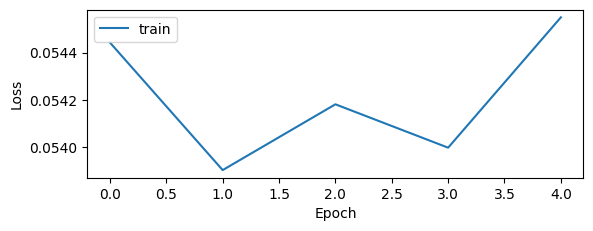

In [21]:
# Gráfica de la evolución de la pérdida y la precisión
plt.subplot(2, 1, 1)
plt.plot(train_loss_history, label='train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Predicción: glass
Real: cardboard


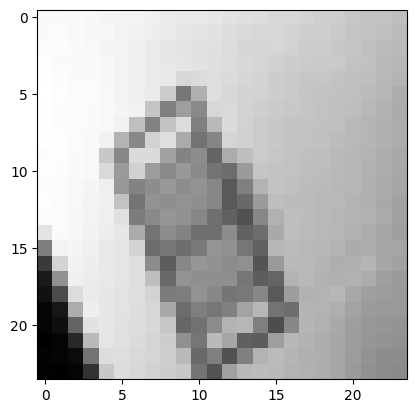

In [22]:
# Visualización de resultados
x, y = next(iter(test_dataloader))
y_pred = model(x.to(device))

# Probamos con una imagen aleatoria del dataset de test
i = random.randint(0, len(x)-1)
plt.imshow(x[i, 0], cmap='gray');
print('Predicción: {}'.format(dataset_train.classes[y_pred.argmax(dim=1)[i]]))
print('Real: {}'.format(dataset_train.classes[y[i]]))

In [44]:
models_path = os.path.join('..','PIC', 'models')
model = torch.load(os.path.join(models_path, 'ResNet50.pt')).to(device)

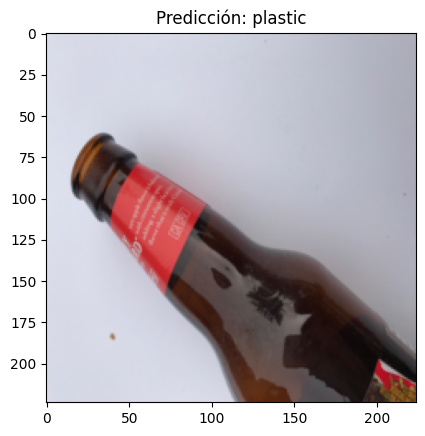

In [48]:
from PIL import Image
# Ruta de la imagen que deseas predecir
image_path = os.path.join('..','clase','glass19.jpg')
image = Image.open(image_path)

# Aplicar la transformación
transformed_image = transf(image)

transformed_image = transformed_image.unsqueeze(0)  # Añadir dimensión de batch
transformed_image = transformed_image.to(device)  # Enviar al dispositivo

y_pred = model(transformed_image.to(device))


# Mostrar la imagen
plt.imshow(transformed_image.squeeze().permute(1, 2, 0))
plt.title('Predicción: {}'.format(dataset_train.classes[y_pred.argmax(dim=1)]))
plt.show()